# Exercice Machine Learning Selectra

Arnaud Fabre 2018

In [1]:
# DataScience libs
import pandas as pd
import numpy as np

In [2]:
# DataViz libs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Reading data
data_read = pd.read_csv("data_music_replay_train")
data = data_read.copy()

## Showing correlations

The very first step of a machine learning process is to understand the data.

In [4]:
# Show a sample of the data
data.sample(4)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,language,remaining_days
342794,1248,20511,my library,Local playlist more,local-library,0,5,29,female,3,2014-10-25,2017-11-18,289018,465,3.0,1120
599967,20240,64281,discover,Online playlist more,online-playlist,0,6,23,male,3,2012-06-07,2018-06-06,193654,444,31.0,2190
619226,22107,22556,radio,Radio,radio,1,22,29,male,3,2016-02-27,2017-10-29,254223,465,3.0,610
40748,14194,13255,discover,Discover Feature,song-based-playlist,0,1,0,NaN,7,2012-01-10,2017-09-10,259526,465,3.0,2070


In [5]:
# Show feature properties
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
msno,663957.0,13659.028247,7873.546059,0.0,6854.0,13723.0,20526.0,27218.0
song_id,663957.0,56475.518228,32723.693649,0.0,28015.0,56246.0,84349.0,113332.0
target,663957.0,0.502484,0.499994,0.0,0.0,1.0,1.0,1.0
city,663957.0,7.512226,6.643304,1.0,1.0,5.0,13.0,22.0
bd,663957.0,17.535374,21.499614,-43.0,0.0,21.0,29.0,1030.0
registered_via,663957.0,6.793684,2.275819,3.0,4.0,7.0,9.0,13.0
song_length,663957.0,245059.429103,67391.013986,1950.0,214622.0,241684.0,272195.0,7575835.0
language,663953.0,18.598420,21.186004,-1.0,3.0,3.0,52.0,59.0
remaining_days,663957.0,1627.231030,1127.995910,-16191.0,701.0,1434.0,2286.0,5149.0


We have to transform categorical feature into numerical feature as ML algorithms use numerical feature

In [6]:
# Identify possible issues with some columns
data.dtypes

msno                        int64
song_id                     int64
source_system_tab          object
source_screen_name         object
source_type                object
target                      int64
city                        int64
bd                          int64
gender                     object
registered_via              int64
registration_init_time     object
expiration_date            object
song_length                 int64
genre_ids                  object
language                  float64
remaining_days              int64
dtype: object

In [7]:
# genre_ids is a combination of differents types
# We are going to get value that are not numbers
not_numbers = data_read.genre_ids.astype(str).apply(lambda x: x.isnumeric()) == False
data_read["genre_ids"][not_numbers.values].sample(10)

202041      1616|1609
188369            NaN
237769    139|125|109
627526      1616|1609
7580          921|465
495355            NaN
79371        465|2022
303489       465|1259
245525        465|921
90471             NaN
Name: genre_ids, dtype: object

We see that some element have multiple genre or not, for our first algorith we will only select the first genre

In [8]:
data["bd"].describe()

count    663957.000000
mean         17.535374
std          21.499614
min         -43.000000
25%           0.000000
50%          21.000000
75%          29.000000
max        1030.000000
Name: bd, dtype: float64

bd is the age so it should not be negative or 0 we will replace outliers with the median value

In [9]:
data.isnull().any()

msno                      False
song_id                   False
source_system_tab          True
source_screen_name         True
source_type                True
target                    False
city                      False
bd                        False
gender                     True
registered_via            False
registration_init_time    False
expiration_date           False
song_length               False
genre_ids                  True
language                   True
remaining_days            False
dtype: bool

We see that some language are NaN, let see more in depth

In [10]:
data[data.language.isnull()]

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,language,remaining_days
130402,3455,91022,my library,Local playlist more,local-library,0,1,0,NaN,4,2016-03-21,2017-10-12,178654,444,NaN,570
151286,21256,91022,discover,Online playlist more,online-playlist,0,13,40,male,9,2009-09-21,2017-09-30,178654,444,NaN,2931
297675,13796,91022,my library,Local playlist more,local-library,0,1,0,NaN,7,2011-08-16,2017-09-08,178654,444,NaN,2215
359198,887,91022,discover,Discover Genre,online-playlist,1,15,37,male,4,2017-01-09,2017-10-11,178654,444,NaN,275


We only have a few NaN we will set a default value for these

In [11]:
def cat_gender(g):
    if g == "male":
        return 1
    elif g == "female":
        return -1
    else:
        return 0
    
def cat_genre(g):
    # Select first genre
    try:
        return(int(g))
    except:
        if isinstance(g, str):
            return g.split("|")[0]
        else:
            return 0

def snd_genre(g):
    # Select first genre
    try:
        return g.split("|")[1]
    except:
        return 0
        
def correct_language(l):
    if l is None or l < 0:
        return 0
    return l

def genre_id_count(x):
    try:
        return x.count("|") + 1
    except:
        return 1

data = data_read.copy()
bd_median = data_read.loc[(data.bd > 0) & (data.bd < 100), "bd"].median()
data.loc[data.bd > 100, "bd"] = bd_median
data.loc[data.bd <= 0, "bd"] = bd_median
data["gender"] = data["gender"].apply(cat_gender)
data["source_type"] = data["source_type"].astype("category").cat.codes
data["source_screen_name"] = data["source_screen_name"].astype("category").cat.codes
data["source_system_tab"] = data["source_system_tab"].astype("category").cat.codes
data["genre_count"] = data["genre_ids"].apply(genre_id_count)
data["genre_id"] = data["genre_ids"].apply(cat_genre)
#data["snd_genre_id"] = data["genre_ids"].apply(snd_genre)
data["language"] = data["language"].apply(correct_language).fillna(0)
data.drop(["registration_init_time", "expiration_date", "genre_ids"], axis=1, inplace=True)
data_first_pass = data.copy()

/home/arnaud/.virtualenvs/p3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


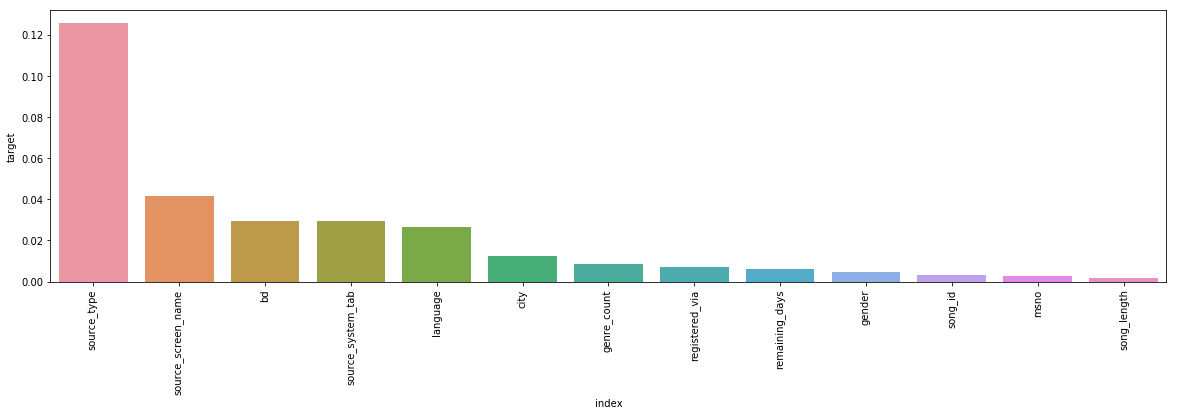

In [12]:
# Correlation value with column "target"
corr = data.corr()[["target"]].abs().sort_values(by="target", ascending=False).reset_index()
# drop target/target correlation
corr.drop(0, inplace=True)
fig = plt.figure(figsize=(20,5));
plt.xticks(rotation=90)
sns.barplot(x="index", y="target", data=corr, ax=plt.subplot(111))

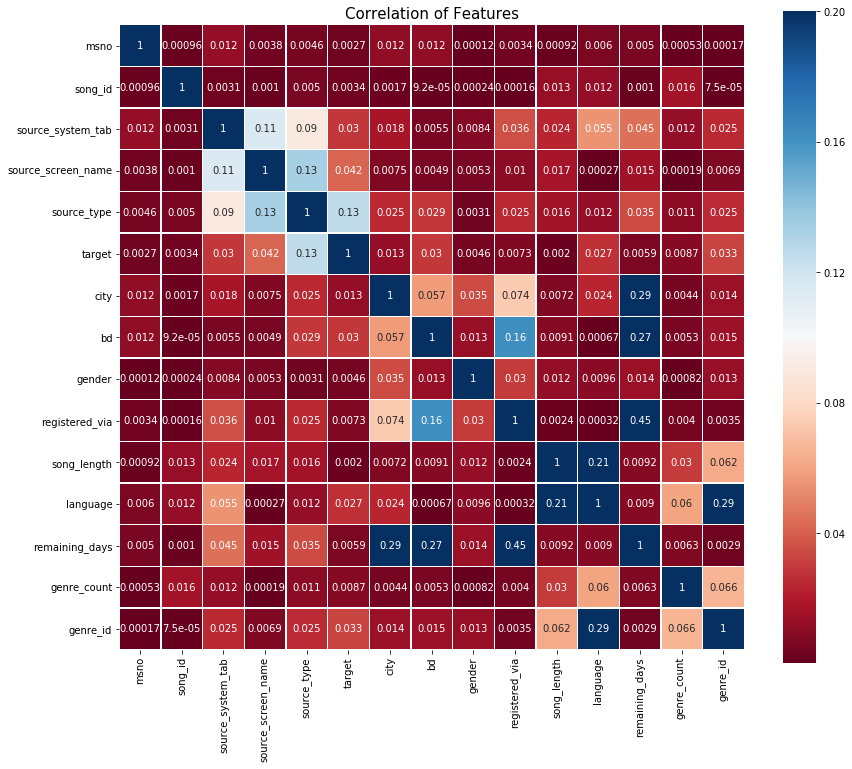

In [13]:
plt.figure(figsize=(14,12))
plt.title("Correlation of Features", y=1, size=15)
sns.heatmap(data.astype(float).corr().abs(), linewidths=0.1,vmax=0.2, square=True, cmap=plt.cm.RdBu, linecolor="white", annot=True)

### Removing categorical value

In [14]:
data = data_first_pass.copy()
# Bins continous values
bins = ["bd", "song_length"]
for column in bins:
    data[column] = pd.qcut(data[column], q=4, labels=False)
# One Hot Encoding
ohe = ["source_type", "source_screen_name", "source_system_tab", "language", "registered_via", "city"] + bins
data = pd.get_dummies(data, prefix=ohe, columns=ohe, drop_first=True)
# Change feature to its frequency
data["song_freq"] = data.groupby("song_id")["song_id"].transform("count")
data["user_freq"] = data.groupby("msno")["msno"].transform("count")
data["genre_freq"] = data.groupby("genre_id")["genre_id"].transform("count")

data.drop(["msno", "song_id", "genre_id", "remaining_days"], axis=1, inplace=True)

In [15]:
data[
    ["song_freq", "user_freq", "genre_freq", "target"]
].astype(float).corr().abs()

,song_freq,user_freq,genre_freq,target
song_freq,1.000000,0.148350,0.029683,0.154634
user_freq,0.148350,1.000000,0.010009,0.003318
genre_freq,0.029683,0.010009,1.000000,0.019161
target,0.154634,0.003318,0.019161,1.000000


# ML - Training

In [16]:
# Utilities
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import preprocessing

First we split the dataset into 3 part : training / testing

This step is really important to not overfitting our model by training it on the test set.

- Training set is used to train our model
- Testing set is used to calculate our model accuracy

The learning algorithm must not see at all any data of the test set!

## Preprocessing

ML algorithms works better with normalized (0 to 1) and standardized (mean = 0, σ = 1) values

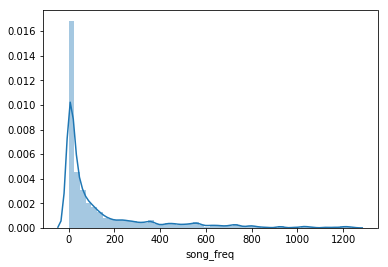

In [17]:
sns.distplot(data.song_freq)

In [26]:
from sklearn.model_selection import train_test_split
seed = 444
data_fit = data.copy()
X_all_full = data_fit.drop("target", axis=1)
y_all_full = data_fit["target"]

# Many classifier excepts data to be normalized
scaler = preprocessing.StandardScaler()
minmax = preprocessing.MinMaxScaler()
# Standard scale gaussian distributed value
columns = ["song_freq", "user_freq", "genre_count", "genre_freq"]
X_all_full[columns] = scaler.fit_transform(X_all_full[columns])

# For the sake of simplicity we will demonstrate algorithms on a really small subset of the data, to keep calculation short
X_train, X_test, y_train, y_test = train_test_split(X_all_full, y_all_full, test_size=0.80, random_state=seed)

## Fitting

In [27]:
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

#### First classifiers

In [28]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
print(clf.__class__.__name__)
print(accuracy_score(y_test, clf.predict(X_test)))

GradientBoostingClassifier
0.650553687548


In [29]:
classifiers = {}
for clf_class in [LogisticRegression, RandomForestClassifier, GaussianNB, DecisionTreeClassifier, GradientBoostingClassifier]:
    clf = clf_class()
    clf.fit(X_train, y_train)
    classifiers[clf.__class__.__name__] = clf
    print(clf.__class__.__name__)
    print(accuracy_score(y_test, clf.predict(X_test)))

LogisticRegression
0.643727196394
RandomForestClassifier
0.612917618974
GaussianNB
0.599066958352
DecisionTreeClassifier
0.570589985052
GradientBoostingClassifier
0.650557452849


#### Fine tunning classifier parameters

We will use [grid search](http://scikit-learn.org/stable/modules/grid_search.html) to fine tune classifiers' parameters.

Since sklearn claissifiers api are all similar we can use a helper class to do the grid search.

In [30]:
class SkLeanrnClassifier:
    def __init__(self, clf, parameters, X_train, y_train):
        self.clf = clf
        self.parameters = parameters
        self.X_train = X_train
        self.y_train = y_train
        
    def grid_search(self):
        acc_scorer = make_scorer(accuracy_score)

        # Run the grid search
        grid_obj = GridSearchCV(self.clf, self.parameters, scoring=acc_scorer, n_jobs=-1, cv=5)
        grid_obj = grid_obj.fit(X_train, y_train)

        # Set the clf to the best combination of parameters
        return grid_obj

In [31]:
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=10/1000)
clf.fit(X_train, y_train)
print(clf.__class__.__name__)
print(accuracy_score(y_test, clf.predict(X_test)))

GradientBoostingClassifier
0.650380483691


In [24]:
parameters = [{
    "n_estimators": [n_tree],
    "learning_rate": [2/n_tree, 5/n_tree, 10/n_tree],
    #"min_samples_leaf": [7, 9, 13],
    "max_depth": [4, 6, 8, 10],
    #"max_features": [100, 150, 250],
} for n_tree in [100, 1000, 10000]]

"""
grid_search = SkLeanrnClassifier(GradientBoostingClassifier(), parameters, X_train, y_train).grid_search()
clf = grid_search.best_estimator_
print(clf.__class__.__name__)
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
"""

'\ngrid_search = SkLeanrnClassifier(GradientBoostingClassifier(), parameters, X_train, y_train).grid_search()\nclf = grid_search.best_estimator_\nprint(clf.__class__.__name__)\npredictions = clf.predict(X_test)\nprint(accuracy_score(y_test, predictions))\nprint(classification_report(y_test, predictions))\n'

## Analysis

##### Feature importance

We see that these classifiers don't use the same feature with the same importance, that means that we can hope to get better results with combining theses classifiers.

In [25]:
eclf1 = VotingClassifier(estimators=[
        ("ada", classifiers["AdaBoostClassifier"]), 
        ("rf", classifiers["RandomForestClassifier"]), 
        ("gb", classifiers["GradientBoostingClassifier"])
    ], 
    voting="hard")
eclf1 = eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

KeyError: 'AdaBoostClassifier'

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
bagging.fit(X_train, y_train)
predictions = bagging.predict(X_test)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))